## Segmenting a single cell from a volume image

In order to remap a cell surface in u-Unwrap3D, the cell must be first segmented from the volumetric image and a surface mesh created. This workbook walks through this process. 

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> The segmentation shown here is extremely basic. It assumes the entirety of the cell is bright and the signal-to-contrast is good such that cell edges are clearly discriminated. An ideal segmentation is where the whole volume of the cell is binary (i.e. infilled) and the protrusions are well-represented. 
</div>

**Warning concerning segmentation**: 
In order to ensure the extracted mesh truly captures the surface, it is crucial to check in this step that the binary image is indeed capturing the whole cell such that the interior cell volume is 'filled'. An easy check is to visualize a mid-section slice of the binary, and check the interior all has the equivalent of a binary 1. If this is not true, the cell will be 'double-meshed' and the extracted 'surface' actually represents the exterior shell. Whilst u-Unwrap3D can handle these imperfect surface meshes, they do affect quantification e.g. you will measure approximately twice larger surface area, and a very small cell volume. 

### Binary segmentation with Otsu thresholding

We read in the volume image used in Fig.1 of the paper and also create a savefolder to store the results of analysis.

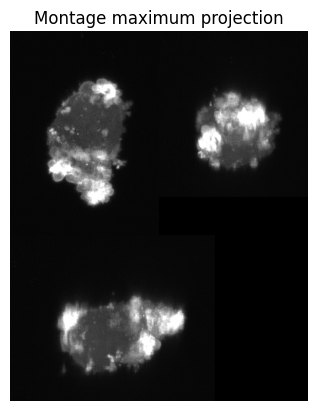

In [9]:
import skimage.io as skio 
import os 
import numpy as np 
import pylab as plt 

import unwrap3D.Visualisation.volume_img as vol_img_viz # for creating a montage maximum projection
import unwrap3D.Utility_Functions.file_io as fio # for common IO functions

imgfolder = 'example_data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')

basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

"""
Initialise a save folder to store the important outputs for the result of the pipeline.
"""
savefolder = os.path.join('example_results', 
                         basefname,
                         'step0_cell_segmentation')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


"""
Read and display image
"""
# read the image using scikit-image
img = skio.imread(imgfile)

# utility function in u-Unwrap3D to generate a montage maximum projection of the 3 orthogonal views for display
img_proj = vol_img_viz.montage_vol_proj(img, np.max)


plt.figure()
plt.title('Montage maximum projection')
plt.imshow(img_proj, cmap='gray')
plt.grid('off')
plt.axis('off')
plt.savefig(os.path.join(savefolder,
                        basefname+'_max-proj_three.png'), dpi=300, bbox_inches='tight')
plt.show()


Since the signal-to-noise ratio of this is good, we segment with an intensity threshold automatically determined from Otsu's method from the scikit-image library.

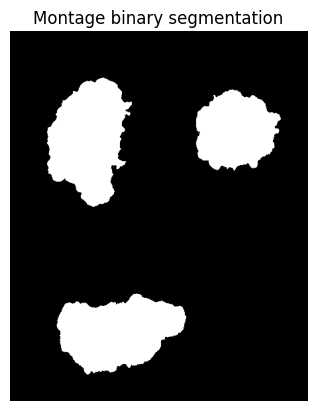

In [10]:
import unwrap3D.Segmentation.segmentation as segmentation # import the segmentation submodule which wraps the Otsu method
import scipy.ndimage as ndimage # use instead of scikit-image for faster morphological operations in 3D
import skimage.morphology as skmorph

# returns the binary and the auto determined threshold. 
img_binary, img_binary_thresh = segmentation.segment_vol_thresh(img)
# erode by ball kernel radius = 1 to make a tighter binary
img_binary = ndimage.binary_erosion(img_binary, 
                                    iterations=1, 
                                    structure=skmorph.ball(1))
img_binary_proj = vol_img_viz.montage_vol_proj(img_binary, np.max)

plt.figure()
plt.title('Montage binary segmentation')
plt.imshow(img_binary_proj, cmap='gray')
plt.grid('off')
plt.axis('off')
plt.savefig(os.path.join(savefolder,
                         basefname+'_binary_three.png'), dpi=300, bbox_inches='tight')
plt.show()

"""
Save the binary out as a uint8 .tif
"""
skio.imsave(os.path.join(savefolder,
                         basefname+'_binary_seg.tif'), 
            np.uint8(255*img_binary))


### Surface meshing the binary segmentation

We mesh the binary segmentation (0 or 1 value) using [marching cubes](https://en.wikipedia.org/wiki/Marching_cubes) at an isovalue of 0.5. The triangles obtained from this are very heterogeneous. Ideally, in mesh analysis, triangles should be close to regular and equilateral. This is particularly important for later steps where we need to solve differential equations on the mesh. Therefore we apply remeshing on the marching cubes output. 

u-Unwrap3D provides two isotropic remeshing algorithms: 1) [pyacvd](https://github.com/pyvista/pyacvd) which uses voronoi clustering or 2) the incremental method of Botsch in [CGAL](https://doc.cgal.org/latest/Polygon_mesh_processing/index.html) based on splitting long edge lengths and collapsing short ones to obtain uniform triangles of a desired length.

We developed u-Unwrap3D initially using method 1 which does not work without requesting an output mesh with fewer vertices (typically at least < 0.5x starting number of vertices). We have since found that the Botsch method is more robust, computable for output mesh with more, same and less vertices, and it better preserves 'sharp' high curvature features. This is now our recommended method, and is used here. 

In [11]:
import unwrap3D.Mesh.meshtools as meshtools # load in the meshtools submodule

img_binary_surf_mesh = meshtools.marching_cubes_mesh_binary(img_binary.transpose(2,1,0), # The transpose is to be consistent with ImageJ rendering and Matlab convention  
                                                                presmooth=1., # applies a presmooth
                                                                contourlevel=.5,
                                                                remesh=True,
                                                                remesh_method='CGAL', # 'pyacvd' = method 1, 'CGAL' = method 2
                                                                remesh_samples=.5, # remeshing with a target #vertices. 0.5 = 50% of original vertex number
                                                                predecimate=False, # this applies quadric mesh simplication to remove very small edges before remeshing. This must be True if using method 1, 'pyacvd'
                                                                min_mesh_size=10000, # enforce at least this number of vertices.
                                                                upsamplemethod='inplane') # upsample the mesh if after the simplification and remeshing < min_mesh_size  
"""
A quick way to check the genus is to get the euler number. The genus of the mesh is related to the euler number by
A genus-0 mesh should have euler number = 2
"""
print('Euler characteristic of mesh is: ', img_binary_surf_mesh.euler_number) #should be 2 if genus is 0

# we also provide a more comprehensive function for common mesh properties
mesh_property = meshtools.measure_props_trimesh(img_binary_surf_mesh, main_component=True, clean=True) 

print(mesh_property) # note: if we have a proper surface mesh, 'volume'=True, Technically the mesh should also be 'watertight' but this is too strict a condition and often doesn't hold true for meshes of complex cell surface morphologies obtained from cell segmentation.

# we also provide a function to check triangle quality. 
triangle_property = meshtools.measure_triangle_props(img_binary_surf_mesh, clean=True)
print(triangle_property)


Euler characteristic of mesh is:  2
{'convex': False, 'volume': True, 'watertight': True, 'orientability': True, 'euler_number': 2, 'genus': 0.0}
{'min_angle': 31.001835560609603, 'avg_angle': 60.000000000000014, 'max_angle': 104.81219458015215, 'std_dev_angle': 8.923689441212806, 'min_quality': 0.654771104193233, 'avg_quality': 0.965323078564477, 'max_quality': 0.9999994081997989, 'quality': array([0.9766652 , 0.95054543, 0.96960764, ..., 0.73999298, 0.82937982,
       0.83884083]), 'angles': array([[1.05132536, 0.89254217, 1.19772513],
       [0.80075156, 1.20338585, 1.13745524],
       [0.91410565, 1.25104304, 0.97644396],
       ...,
       [1.70714756, 0.75943757, 0.67500753],
       [1.56349544, 0.74061199, 0.83748522],
       [1.53577656, 0.71951787, 0.88629823]])}


### Mean curvature measurement from binary segmentation

There are many ways to determine the mean curvature of the surface with different pros and cons. 

1. **From surface mesh**

Measuring surface mean curvature typically involves fitting a local plane to neighborhood vertices of a surface mesh. see: `unwrap3D.Mesh.meshtools.compute_mean_curvature`. If the surface mesh has topological errors, e.g. containing holes, this measurement is not accurate. It can also be subject to the quality of the triangle faces and choice of neighborhood radius. 

2. **From binary segmentation**

We find it easier and more accurate for downstream quantification to measure curvature from the continuous definition of mean curvature, $H$ using the binary segmentation whereby we can easily apply morphological operations like dilation and hole-filling to fix small mesh errors.

$$ H = {-\frac{1}{2} \nabla \cdot \hat{n}} $$

where $\hat{n}$ is the unit surface normal vector, and also the gradient of the signed distance function $\Phi$ of the binary segmentation.

$$ \hat{n} = {\nabla \Phi} $$
A major advantage of this technique is that any small holes and mesh imperfection are fixed in the binary through morphological operations. 

The curvature at the surface is obtained by interpolating at the mesh vertices. 

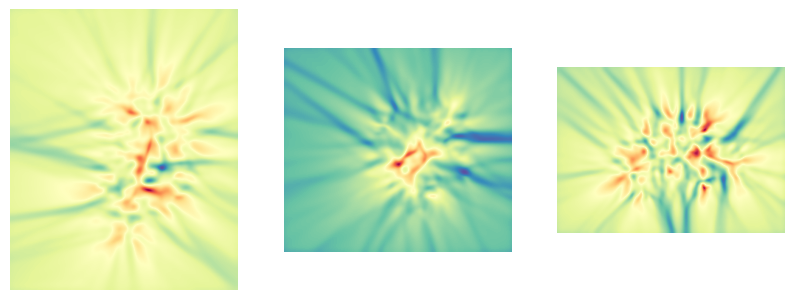

In [12]:
import unwrap3D.Mesh.meshtools as meshtools

# compute the continuous mean curvature definition and smooth slightly with a Gaussian of sigma=3.  
surf_H, (H_binary, H_sdf_vol_normal, H_sdf_vol) = meshtools.compute_mean_curvature_from_binary(img_binary_surf_mesh, 
                                                                                    img_binary.transpose(2,1,0), 
                                                                                    smooth_gradient=3, # adjusts smoothing, plays similar role to neighborhood radius in mesh method
                                                                                    eps=1e-12,
                                                                                    invert_H=False, # set True if you want positive values to correspond to positive curvature on the surface like blebs and binary is not transposed, otherwise set False. 
                                                                                    return_H_img=True) # set return_H_img to be True, if 

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(np.nanmean(H_binary,axis=0), cmap='Spectral_r'); plt.grid('off'); plt.axis('off')
plt.subplot(132)
plt.imshow(np.nanmean(H_binary,axis=1), cmap='Spectral_r'); plt.grid('off'); plt.axis('off')
plt.subplot(133)
plt.imshow(np.nanmean(H_binary,axis=2), cmap='Spectral_r'); plt.grid('off'); plt.axis('off')
plt.show()

In [13]:
import unwrap3D.Image_Functions.image as image_fn # for common image processing functions
import unwrap3D.Visualisation.colors as vol_colors # this is for colormapping any np.array using a color palette 
from matplotlib import cm # this is for specifying a matplotlib color palette


"""
We map the curvature values to a colorscheme for display. To set the scale, we use the voxel size to convert to metric units of $\mu m^{-1}$
"""
# we generate colors from the mean curvature 
voxel_size = 0.104 #um
surf_H_colors = vol_colors.get_colors(surf_H/voxel_size, # 0.104 is the voxel resolution -> this converts to um^-1 
                                      colormap=cm.Spectral_r, 
                                      vmin=-1., 
                                      vmax=1.) # colormap H with lower and upper limit of -1, 1 um^-1. 

# set the vertex colors to the computed mean curvature color
img_binary_surf_mesh.visual.vertex_colors = np.uint8(255*surf_H_colors[...,:3]) 

# save the mesh for viewing in an external program such as meshlab which offers much better rendering capabilities
tmp = img_binary_surf_mesh.export(os.path.join(savefolder, 'curvature_binary_mesh_'+basefname+'.obj')) # tmp is used to prevent printing to screen.


The saved surface mesh is in .obj format. These are best viewed in a dedicated mesh viewer such as [meshlab](https://www.meshlab.net/), or [chimerax](https://github.com/RBVI/ChimeraX) which are opensource, free and cross-platform. 

Within python, we can get an idea without installing more specialized libraries such as [vedo](https://vedo.embl.es/) by 3D scatter plotting and coloring the mesh vertices with matplotlib.

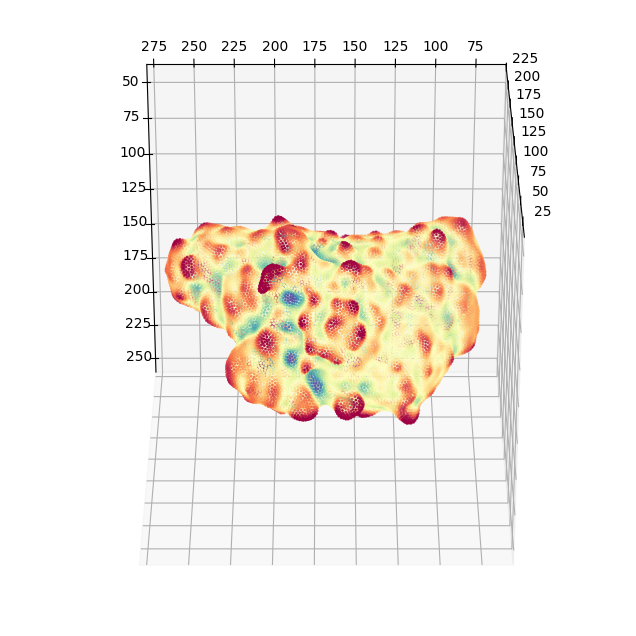

In [14]:
# the mesh is best viewed in a dedicated mesh viewer such as meshlab which is opensource, free and cross-platform. We can get an idea by plotting and coloring the mesh vertices using matplotlib

import unwrap3D.Visualisation.plotting as plotting # we import this so we can make x,y,z axes be plotted in equal proportions. 

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(img_binary_surf_mesh.vertices[...,2], 
           img_binary_surf_mesh.vertices[...,1],
           img_binary_surf_mesh.vertices[...,0], 
           s=1, 
           c=surf_H/.104, 
           cmap='Spectral_r', 
           vmin=-1,
           vmax=1)
ax.view_init(-60, 180)
plotting.set_axes_equal(ax)
plt.show()

### Map surface proximal membrane signals by traversing along the gradient of a distance transform into the cell

We can use active contour conformalized mean curvature flow, (see the u-Unwrap3D [paper](https://www.biorxiv.org/content/10.1101/2023.04.12.536640v2)) to traverse into the cell and sample the image intensity at designed step sizes $\alpha$ along the gradient of a signed distance function. We can then average the sampled intensity and map this onto the cell surface. We do this for our cell up to 1 $\mu m$ depth. Our image has an isotropic voxel resolution of 0.104 $\mu m$. We sample this depth in steps of 0.5 voxels. This equates to a total of 1./(0.104*0.5) steps rounded down to the nearest integer. 

In [15]:
n_samples = 1./ voxel_size # total number of steps
stepsize = 0.5 # voxels
    
# flip the mesh vertex coordinates so that it aligns with the volume size 
img_binary_surf_mesh.vertices = img_binary_surf_mesh.vertices[:,::-1].copy()

# run the active contour cMCF to get the coordinates at different depths into the cell according to the external image gradient given by the gradient of the signed distance function.
v_depth = meshtools.parametric_mesh_constant_img_flow(img_binary_surf_mesh, 
                                                      external_img_gradient = H_sdf_vol_normal.transpose(1,2,3,0), 
                                                      niters=int(n_samples/stepsize), 
                                                      deltaL=5e-5, # delta which controls the stiffness of the mesh
                                                      step_size=stepsize, 
                                                      method='implicit', # this specifies the cMCF solver.
                                                      conformalize=True) # ensure we use the cMCF Laplacian

# we can check the size of the array
print(v_depth.shape)

# we can plot the trajectory with matplotlib 

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:23<00:00,  1.21s/it]

(23745, 3, 20)


**Implementation Warning Note:**

We typically use the signed distance function given by the Euclidean distance transform (EDT) as illustrated above to deform the mesh and sample the intensities, as it is fast to compute and memory-efficient. However, when sampling thin, narrow, and long protrusions. The result of the EDT will look 'blocky'. In these cases, it is more optimal to compute the signed distance function given by solving the Poisson equation (see: `unwrap3D.Segmentation.segmentation.poisson_dist_tform_3D`). However, our current implementation uses an exact LU solver which is slow and will likely memory error. We recommend computing the distance transform on the isotropically downsampled binary segmentation (e.g. 1/8th), then resizing the result to the original size. This is valid because the distance transform is smooth.  

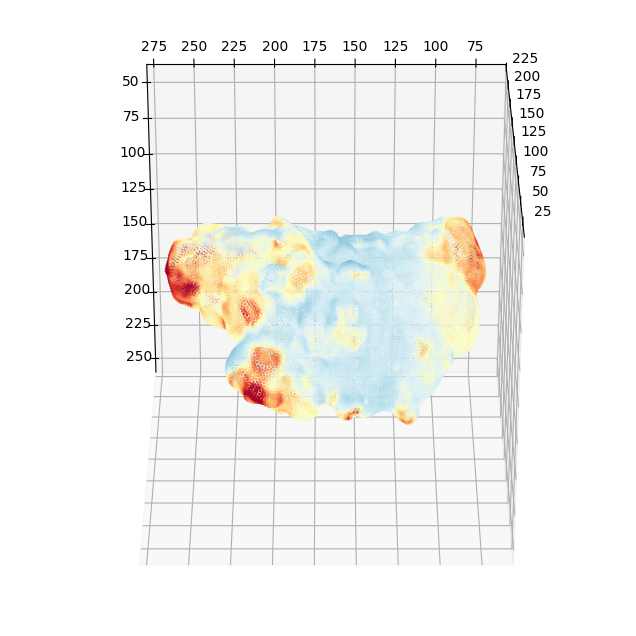

In [16]:
# get the intensities at the sampled depth coordinates. 
v_depth_I = image_fn.map_intensity_interp3(v_depth.transpose(0,2,1).reshape(-1,3), 
                                            img.shape, 
                                            I_ref=img)
v_depth_I = v_depth_I.reshape(-1,v_depth.shape[-1]) # matrix reshaping into a nicer shape. 

# postprocess to check the total distance from the surface does not exceed the desired and replace any nans.  
dist_v_depth0 = np.linalg.norm(v_depth - v_depth[...,0][...,None], axis=1)
valid_I = dist_v_depth0<=n_samples
v_depth_I[valid_I == 0 ] = np.nan # replace with nans


# compute the mean sampled intensity which will be taken as the surface intensity. 
surf_intensity_img_raw = np.nanmean(v_depth_I, axis=1)
surf_intensity_img_raw[np.isnan(surf_intensity_img_raw)] = 0

# for visualization, we find the intensity range to be more pleasing if clipped to between the 1st and 99th percentile. 
I_min = np.percentile(surf_intensity_img_raw,1)
I_max = np.percentile(surf_intensity_img_raw,99)

surf_intensity_img_raw_colors = vol_colors.get_colors(surf_intensity_img_raw, 
                                                      colormap=cm.RdYlBu_r,   
                                                      vmin=I_min, 
                                                      vmax=I_max)
# create a new surface mesh, now with the PI3K molecular signal colors. 
img_binary_surf_mesh_colors = meshtools.create_mesh(vertices=img_binary_surf_mesh.vertices[:,::-1],
                                                  faces=img_binary_surf_mesh.faces, 
                                                  vertex_colors=np.uint8(255*surf_intensity_img_raw_colors[...,:3])) 
tmp = img_binary_surf_mesh_colors.export(os.path.join(savefolder, 
                                                'PI3K_binary_mesh_'+basefname+'.obj')) # tmp is used to prevent printing to screen.


# again we can quickly view the coloring in matplotlib
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(img_binary_surf_mesh_colors.vertices[...,2], 
           img_binary_surf_mesh_colors.vertices[...,1],
           img_binary_surf_mesh_colors.vertices[...,0], 
           s=1, 
           c=surf_intensity_img_raw, 
           cmap='RdYlBu_r', 
           vmin=-I_min,
           vmax=I_max)
ax.view_init(-60, 180)
plotting.set_axes_equal(ax)
plt.show()


# finally we will save the actual numerical values of the surface curvature and intensity to avoid recomputation to use for other steps of the pipeline
import scipy.io as spio # we save in .mat, this will allow matlab users to use the output if desired
spio.savemat(os.path.join(savefolder, 
                          basefname+'_surface_curvature_intensity_stats.mat'), 
            {'surf_H': surf_H,
             'surf_intensity' : surf_intensity_img_raw})

## We now proceed to step 1 notebook to run conformalized mean curvature flow and derive a genus-0 reference shape ...